# Liquid Crystal Discovery: LightGBM + W&B (Tables, Molecules, Callbacks)

このNotebookは、分子の SMILES とテキスト（description）から

- サーモトロピック液晶かどうかの確率（Classification）
- 透明点 Tc（Regression、主に LC のみ）

を予測します。あわせて W&B で以下を行います。

- LightGBM の学習曲線を `wandb.integration.lightgbm.wandb_callback()` で自動ロギング
- `log_summary()` で特徴量重要度プロットとモデルチェックポイント保存
- `wandb.Table` に train と test を別テーブルとして保存
  - `wandb.Molecule` により UI 上で分子構造を回転・ズームして確認
  - RDKit 画像も併記（任意で行数制限）
  - train は Tc の正解（Actual）と OOF 予測（Pred）を両方含め、UI 上で散布図がすぐ描ける
  - test は Pred のみ
  - ECFP4 を 0/1 のリストで 1 カラムに保持し、UI 上の PCA / UMAP / t-SNE に使える

実行環境は Kaggle Notebook を想定しています。


## 0. W&B 環境変数

上のセルで `WANDB_ENTITY` と `WANDB_PROJECT` を設定してください。

- 既に環境変数がある場合はそれを優先します
- `WANDB_MODE` は `online` / `offline` / `disabled` が使えます


In [1]:
import os
from datetime import datetime

# 既に環境変数が設定されていればそれを優先
os.environ["WANDB_ENTITY"] = "wandb-japan" # 自分のentityを入れる
os.environ["WANDB_PROJECT"] = "data-science-osaka-winter-2025-simple-baseline"

from kaggle_secrets import UserSecretsClient
secret_label = "WANDB_API_KEY"
os.environ["WANDB_API_KEY"] = UserSecretsClient().get_secret(secret_label)


# Base group to keep runs together (timestamped)
BASE_GROUP = os.environ.get("WANDB_BASE_GROUP", "")
if not BASE_GROUP:
    BASE_GROUP = f"lc-sample-{datetime.now().strftime('%Y%m%d-%H%M%S')}"
    os.environ["WANDB_BASE_GROUP"] = BASE_GROUP

CLS_GROUP = f"{BASE_GROUP}-cls"
TC_GROUP  = f"{BASE_GROUP}-tc"
TM_GROUP  = f"{BASE_GROUP}-tm"
TABLE_GROUP = f"{BASE_GROUP}-tables"

print("WANDB_ENTITY:", os.environ.get("WANDB_ENTITY"))
print("WANDB_PROJECT:", os.environ.get("WANDB_PROJECT"))
print("WANDB_MODE:", os.environ.get("WANDB_MODE"))
print("BASE_GROUP:", BASE_GROUP)

WANDB_ENTITY: wandb-japan
WANDB_PROJECT: data-science-osaka-winter-2025-simple-baseline
WANDB_MODE: None
BASE_GROUP: lc-sample-20251219-120259


In [2]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from scipy import sparse

import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score, roc_curve, root_mean_squared_error, mean_squared_error
from scipy.stats import spearmanr

import lightgbm as lgb

import wandb
from wandb.integration.lightgbm import wandb_callback, log_summary

pd.set_option("display.max_columns", None)

SEED = 42
np.random.seed(SEED)

## 1. データ読み込み

In [3]:
# Kaggle の入力パスに合わせて必要に応じて変更してください
INPUT_DIR = "/kaggle/input/data-science-osaka-winter-2025/"
TRAIN_PATH = os.path.join(INPUT_DIR, "train.csv")
TEST_PATH  = os.path.join(INPUT_DIR, "test.csv")
SUB_PATH   = os.path.join(INPUT_DIR, "sample_submission.csv")

train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)
sub   = pd.read_csv(SUB_PATH)

print("train:", train.shape)
print("test :", test.shape)
display(train.head())

train: (1020, 11)
test : (1127, 6)


,row_id,compound_name,smiles_guess,lc_type,phase_transition_behavior,description,smiles_source,group_id,is_liquid_crystal,is_thermotropic_lc,clearing_point_celsius
0,0,4-[(4-nitrophenoxy)carbonyl]phenyl 2-propoxy-4...,CCCOc1cc(OC)ccc1C(=O)Oc1ccc(C(=O)Oc2ccc([N+](=...,Monotropic,Cr 147 I (N 97 I) (NF 85 N),A tri-aryl ester comprising a central 4-hydrox...,New_Gemini,paper_0437,True,0,97.0
1,1,"Poly[oxy(2,4,4,6,6,8,10,10,12,12-decamethyl-5-...",*O[Si]1(C)O[Si](C)(C)C[Si](C)(C)O[Si](C)(O*)O[...,Thermotropic,M 240 I,A cyclolinear polyorganocarbosiloxane polymer ...,New_Gemini,paper_0005,True,1,240.0
2,2,"2,5,9-Tris(3,4-dihexyloxyphenyl)-tris([1,2,4]t...",CCCCCCCOc1c(OCCCCCCC)cc(-n2nc3nc4nn(c5ccc(OCCC...,Thermotropic,Cr 100 M 225 I,A star-shaped heteroaromatic system featuring ...,New_Gemini,paper_0034,True,1,225.0
3,3,"Poly(3,3''-didodecyl-2,2':5',2''-terthiophene)",CCCCCCCCCCCCc1csc(c2csc(c3cc(CCCCCCCCCCCC)s3)s...,No-LC,NaN,A terthiophene-based semiconducting polymer su...,New_Gemini,paper_0157,False,0,NaN
4,4,"N-(3-Trimethoxysilylpropyl)-N,N,N-trimethylamm...",C[N+](C)(C)CCC[Si](OC)(OC)OC.[Cl-],No-LC,NaN,A quaternary ammonium salt functionalized with...,PubChem,paper_0326,False,0,NaN


## 2. 可視化

[12:03:11] Can't kekulize mol.  Unkekulized atoms: 13 14 15 90 91
[12:03:12] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22


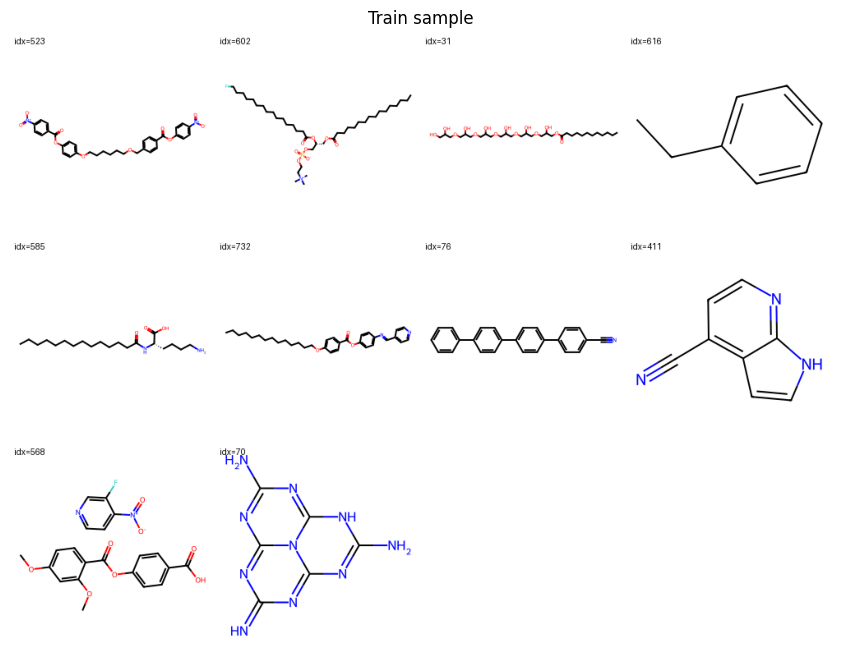

In [4]:
def show_molecule_grid(df, smiles_col="smiles_guess", n=12, title="Molecules"):
    import math
    import numpy as np
    import matplotlib.pyplot as plt
    from rdkit import Chem
    from rdkit.Chem.Draw import rdMolDraw2D
    from PIL import Image, ImageDraw, ImageFont
    from io import BytesIO

    n = min(int(n), len(df))
    sub_w, sub_h = 250, 250
    mols = []
    legends = []

    # valid mol だけ集める
    for i in range(len(df)):
        if len(mols) >= n:
            break
        s = df.iloc[i][smiles_col]
        if not isinstance(s, str) or not s.strip():
            continue
        m = Chem.MolFromSmiles(s)
        if m is None:
            continue
        mols.append(m)
        legends.append(f"idx={df.index[i]}")

    if len(mols) == 0:
        print("表示できるSMILESがありませんでした（無効なSMILES、空文字など）。")
        return

    cols = 4
    rows = math.ceil(len(mols) / cols)

    canvas = Image.new("RGB", (cols * sub_w, rows * sub_h), (255, 255, 255))
    drawer = ImageDraw.Draw(canvas)

    # 環境によってはフォントが無いので fallback 前提
    try:
        font = ImageFont.load_default()
    except Exception:
        font = None

    for idx, (m, leg) in enumerate(zip(mols, legends)):
        r = idx // cols
        c = idx % cols

        # kekulize しないで描く（Can't kekulize 対策）
        try:
            pm = rdMolDraw2D.PrepareMolForDrawing(m, kekulize=False)
        except Exception:
            pm = m

        d2d = rdMolDraw2D.MolDraw2DCairo(sub_w, sub_h)
        d2d.DrawMolecule(pm)
        d2d.FinishDrawing()

        png = d2d.GetDrawingText()
        tile = Image.open(BytesIO(png)).convert("RGB")

        # 右上に idx を薄く表示（任意）
        try:
            drawer_tile = ImageDraw.Draw(tile)
            drawer_tile.text((5, 5), leg, fill=(0, 0, 0), font=font)
        except Exception:
            pass

        canvas.paste(tile, (c * sub_w, r * sub_h))

    plt.figure(figsize=(12, 8))
    plt.imshow(np.asarray(canvas))
    plt.axis("off")
    plt.title(title)
    plt.show()


show_molecule_grid(train.sample(min(12, len(train)), random_state=SEED), title="Train sample")


## 3. 特徴量エンジニアリング

In [5]:
SMILES_COL = "smiles_guess" if "smiles_guess" in train.columns else "smiles"
DESC_COL   = "description"

N_BITS = 2048

def get_ecfp4_numpy(df, col=SMILES_COL, n_bits=N_BITS, radius=2):
    gen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=n_bits)
    arr = np.zeros((len(df), n_bits), dtype=np.int8)
    for i, s in enumerate(df[col].astype(str).values):
        mol = Chem.MolFromSmiles(s)
        if mol is None:
            continue
        fp = gen.GetFingerprintAsNumPy(mol)
        arr[i] = fp.astype(np.int8)
    return arr

print("Generating ECFP4 (numpy + sparse)...")
train_ecfp4_np = get_ecfp4_numpy(train)
test_ecfp4_np  = get_ecfp4_numpy(test)

train_ecfp4 = sparse.csr_matrix(train_ecfp4_np)
test_ecfp4  = sparse.csr_matrix(test_ecfp4_np)

# ECFP4 vector as a python list per row (for W&B embedding tools)
train_ecfp4_list = [row.astype(int).tolist() for row in train_ecfp4_np]
test_ecfp4_list  = [row.astype(int).tolist() for row in test_ecfp4_np]

print("Generating TF-IDF...")
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=2,
    max_features=20000,
)
train_tfidf = tfidf.fit_transform(train[DESC_COL].fillna(""))
test_tfidf  = tfidf.transform(test[DESC_COL].fillna(""))

X = sparse.hstack([train_ecfp4, train_tfidf], format="csr")
X_test = sparse.hstack([test_ecfp4, test_tfidf], format="csr")

print("Feature matrix:", X.shape, "Test:", X_test.shape)

# Targets
y_cls = train["is_thermotropic_lc"].astype(int).values

# Tc column detection
TC_COL = "clearing_point_celsius" if "clearing_point_celsius" in train.columns else None
if TC_COL is None:
    raise ValueError("train.csv に clearing_point_celsius が見つかりません。列名を確認してください。")
y_tc = train[TC_COL].values.astype(float)

# Optional: Tm column detection (ある場合のみ使う)
TM_CANDIDATES = ["melting_point_celsius", "tm_celsius", "Tm_celsius", "melting_point", "Tm", "tm"]
TM_COL = None
for c in TM_CANDIDATES:
    if c in train.columns:
        TM_COL = c
        break
if TM_COL is not None:
    y_tm = train[TM_COL].values.astype(float)
    print("Detected Tm column:", TM_COL)
else:
    y_tm = None
    print("Tm column not found. This notebook will skip Tm modeling and keep NaN columns for tables.")

# Group column
GROUP_COL = "group_id" if "group_id" in train.columns else None
if GROUP_COL is None:
    raise ValueError("train.csv に group_id が見つかりません。StratifiedGroupKFold のために必要です。")
groups = train[GROUP_COL].values

Generating ECFP4 (numpy + sparse)...


[12:03:12] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 49 50 51 52 76 77 78
[12:03:12] Can't kekulize mol.  Unkekulized atoms: 16 17 19
[12:03:12] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 48 63 78
[12:03:12] Can't kekulize mol.  Unkekulized atoms: 13 14 15 105 106
[12:03:12] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 145 146 147
[12:03:12] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27 54 55 56 57 84 85 86
[12:03:12] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 46 47 48 49 69 70 71
[12:03:12] Can't kekulize mol.  Unkekulized atoms: 64 65 66 67 81
[12:03:12] Can't kekulize mol.  Unkekulized atoms: 13 14 15 126 127
[12:03:12] Explicit valence for atom # 5 N, 3, is greater than permitted
[12:03:12] Can't kekulize mol.  Unkekulized atoms: 39 40 41 42 43 85 86 87 88 130 131 132
[12:03:12] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31 61 62 63 64 94 95 96
[12:03:12] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 39 40 41 42 61

Generating TF-IDF...
Feature matrix: (1020, 7317) Test: (1127, 7317)
Tm column not found. This notebook will skip Tm modeling and keep NaN columns for tables.


## 4. 評価指標

In [6]:
def decoupled_rank_score(y_true_cls, y_true_tc, pred_prob, pred_tc, return_parts=False):
    # Classification part: rank-based (Normalized Gini)
    order = np.argsort(pred_prob)
    y_sorted = y_true_cls[order]
    cum_pos = np.cumsum(y_sorted)
    total_pos = cum_pos[-1] if cum_pos.size else 0
    if total_pos == 0:
        norm_gini = 0.0
    else:
        gini = (cum_pos.sum() / total_pos) - (len(y_sorted) + 1) / 2
        gini_max = (np.arange(1, len(y_sorted) + 1).sum()) - (len(y_sorted) + 1) / 2
        norm_gini = gini / gini_max

    # Regression part: Spearman on LC only where Tc is available
    mask = (y_true_cls == 1) & np.isfinite(y_true_tc)
    if mask.sum() < 3:
        rho = 0.0
    else:
        rho = float(spearmanr(y_true_tc[mask], pred_tc[mask]).correlation)
        if np.isnan(rho):
            rho = 0.0

    score = 0.5 * (norm_gini + rho)
    if return_parts:
        return score, norm_gini, rho
    return score

## 5. 交差検証: LightGBM + W&B integration

In [7]:
# LightGBM params
params_cls = {
    "objective": "binary",
    "metric": ["auc"],
    "learning_rate": 0.05,
    "num_leaves": 64,
    "min_data_in_leaf": 30,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "seed": SEED,
    "verbosity": -1,
}

params_tc = {
    "objective": "regression",
    "metric": ["rmse"],
    "learning_rate": 0.03,
    "num_leaves": 64,
    "min_data_in_leaf": 30,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "seed": SEED,
    "verbosity": -1,
}

params_tm = dict(params_tc)

N_SPLITS = 5
sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

oof_prob = np.zeros(len(train), dtype=float)
oof_tc_pred = np.full(len(train), np.nan, dtype=float)
oof_tm_pred = np.full(len(train), np.nan, dtype=float) if y_tm is not None else None

# Feature importance (mean over folds)
feat_names = [f"ecfp4_{i}" for i in range(N_BITS)] + [f"tfidf_{i}" for i in range(train_tfidf.shape[1])]
fi_cls = np.zeros(X.shape[1], dtype=float)
fi_tc  = np.zeros(X.shape[1], dtype=float)
fi_tm  = np.zeros(X.shape[1], dtype=float) if y_tm is not None else None

tags = [t.strip() for t in os.environ.get("WANDB_TAGS", "").split(",") if t.strip()]

fold_scores = []
for fold, (tr_idx, va_idx) in enumerate(sgkf.split(X, y_cls, groups)):
    X_tr, X_va = X[tr_idx], X[va_idx]
    y_tr, y_va = y_cls[tr_idx], y_cls[va_idx]
    tc_tr, tc_va = y_tc[tr_idx], y_tc[va_idx]

    # ---------------------------
    # 5.1 Classification (fold run)
    # ---------------------------
    run_cls = wandb.init(
        entity=os.environ.get("WANDB_ENTITY") or None,
        project=os.environ.get("WANDB_PROJECT") or None,
        group=CLS_GROUP,
        name=f"cls-fold{fold+1}",
        job_type="train",
        tags=tags,
        reinit=True,
        config={
            "seed": SEED,
            "task": "classification",
            "fold": fold,
            "n_splits": N_SPLITS,
            "params": params_cls,
            "features": {"ecfp4_bits": N_BITS, "tfidf_dim": int(train_tfidf.shape[1])},
        },
    )

    dtrain = lgb.Dataset(X_tr, label=y_tr)
    dvalid = lgb.Dataset(X_va, label=y_va, reference=dtrain)

    booster_cls = lgb.train(
        params_cls,
        dtrain,
        valid_sets=[dvalid],
        valid_names=["valid"],
        num_boost_round=5000,
        callbacks=[
            wandb_callback(),  # 学習曲線を自動ロギング
            lgb.early_stopping(200, verbose=False),
            lgb.log_evaluation(period=50),
        ],
    )

    prob_va = booster_cls.predict(X_va, num_iteration=booster_cls.best_iteration)
    oof_prob[va_idx] = prob_va

    # Feature importance
    fi = booster_cls.feature_importance(importance_type="gain")
    fi_cls += fi / N_SPLITS

    # Summary artifacts (feature importance plot + model checkpoint)
    log_summary(booster_cls, save_model_checkpoint=True)

    # Fold AUC
    auc = roc_auc_score(y_va, prob_va)
    wandb.log({"fold/auc": auc})
    run_cls.finish()

    # ---------------------------
    # 5.2 Tc regression (LC only, fold run)
    # ---------------------------
    mask_tr_lc = (y_tr == 1) & np.isfinite(tc_tr)
    mask_va_lc = (y_va == 1) & np.isfinite(tc_va)

    if mask_tr_lc.sum() >= 10 and mask_va_lc.sum() >= 3:
        run_tc = wandb.init(
            entity=os.environ.get("WANDB_ENTITY") or None,
            project=os.environ.get("WANDB_PROJECT") or None,
            group=TC_GROUP,
            name=f"tc-fold{fold+1}",
            job_type="train",
            tags=tags,
            reinit=True,
            config={
                "seed": SEED,
                "task": "regression_tc",
                "fold": fold,
                "n_splits": N_SPLITS,
                "params": params_tc,
                "train_lc_rows": int(mask_tr_lc.sum()),
                "valid_lc_rows": int(mask_va_lc.sum()),
            },
        )

        dtrain_r = lgb.Dataset(X_tr[mask_tr_lc], label=tc_tr[mask_tr_lc])
        dvalid_r = lgb.Dataset(X_va[mask_va_lc], label=tc_va[mask_va_lc], reference=dtrain_r)

        booster_tc = lgb.train(
            params_tc,
            dtrain_r,
            valid_sets=[dvalid_r],
            valid_names=["valid"],
            num_boost_round=8000,
            callbacks=[
                wandb_callback(),
                lgb.early_stopping(300, verbose=False),
                lgb.log_evaluation(period=50),
            ],
        )

        tc_pred_va = booster_tc.predict(X_va, num_iteration=booster_tc.best_iteration)
        # 保存は LC 部分のみ。非 LC は NaN のまま
        oof_tc_pred[va_idx] = np.nan
        oof_tc_pred[va_idx[mask_va_lc]] = tc_pred_va[mask_va_lc]

        fi = booster_tc.feature_importance(importance_type="gain")
        fi_tc += fi / N_SPLITS

        log_summary(booster_tc, save_model_checkpoint=True)

        rmse = root_mean_squared_error(tc_va[mask_va_lc], tc_pred_va[mask_va_lc])
        wandb.log({"fold/rmse": rmse})
        run_tc.finish()
    else:
        # 学習できない fold はスキップしつつ、欠損は NaN のままにする
        pass

    # ---------------------------
    # 5.3 Optional Tm regression (if present)
    # ---------------------------
    if y_tm is not None:
        tm_tr, tm_va = y_tm[tr_idx], y_tm[va_idx]
        mask_tr_tm = np.isfinite(tm_tr)
        mask_va_tm = np.isfinite(tm_va)
        if mask_tr_tm.sum() >= 10 and mask_va_tm.sum() >= 3:
            run_tm = wandb.init(
                entity=os.environ.get("WANDB_ENTITY") or None,
                project=os.environ.get("WANDB_PROJECT") or None,
                group=TM_GROUP,
                name=f"tm-fold{fold+1}",
                job_type="train",
                tags=tags,
                reinit=True,
                config={
                    "seed": SEED,
                    "task": "regression_tm",
                    "fold": fold,
                    "n_splits": N_SPLITS,
                    "params": params_tm,
                    "train_rows": int(mask_tr_tm.sum()),
                    "valid_rows": int(mask_va_tm.sum()),
                },
            )

            dtrain_tm = lgb.Dataset(X_tr[mask_tr_tm], label=tm_tr[mask_tr_tm])
            dvalid_tm = lgb.Dataset(X_va[mask_va_tm], label=tm_va[mask_va_tm], reference=dtrain_tm)

            booster_tm = lgb.train(
                params_tm,
                dtrain_tm,
                valid_sets=[dvalid_tm],
                valid_names=["valid"],
                num_boost_round=8000,
                callbacks=[
                    wandb_callback(),
                    lgb.early_stopping(300, verbose=False),
                    lgb.log_evaluation(period=50),
                ],
            )
            tm_pred_va = booster_tm.predict(X_va, num_iteration=booster_tm.best_iteration)
            oof_tm_pred[va_idx] = tm_pred_va

            fi = booster_tm.feature_importance(importance_type="gain")
            fi_tm += fi / N_SPLITS

            log_summary(booster_tm, save_model_checkpoint=True)
            rmse = root_mean_squared_error(tm_va[mask_va_tm], tm_pred_va[mask_va_tm])
            wandb.log({"fold/rmse": rmse})
            run_tm.finish()

    # Combined fold score (DecoupledRank)
    score, gini, rho = decoupled_rank_score(y_va, tc_va, prob_va, oof_tc_pred[va_idx], return_parts=True)
    fold_scores.append({"fold": fold, "score": score, "norm_gini": gini, "spearman": rho, "auc": auc})
    print(f"Fold {fold+1}: auc={auc:.5f} score={score:.6f} gini={gini:.6f} spearman={rho:.6f}")

# Overall CV
cv_score, cv_gini, cv_rho = decoupled_rank_score(y_cls, y_tc, oof_prob, oof_tc_pred, return_parts=True)
print("CV Total:", cv_score, cv_gini, cv_rho)
display(pd.DataFrame(fold_scores))

# Summary run (no learning curve)
run_sum = wandb.init(
    entity=os.environ.get("WANDB_ENTITY") or None,
    project=os.environ.get("WANDB_PROJECT") or None,
    group=BASE_GROUP,
    name="cv-summary",
    job_type="summary",
    tags=tags,
    reinit=True,
    config={"seed": SEED, "n_splits": N_SPLITS},
)
run_sum.summary["cv_total/score"] = float(cv_score)
run_sum.summary["cv_total/norm_gini"] = float(cv_gini)
run_sum.summary["cv_total/spearman"] = float(cv_rho)
run_sum.log({"cv/folds": wandb.Table(dataframe=pd.DataFrame(fold_scores))})

# Log mean feature importance tables
def log_fi_table(run, fi, title, topn=50):
    idx = np.argsort(fi)[::-1][:topn]
    df = pd.DataFrame({"feature": np.array(feat_names)[idx], "importance_gain": fi[idx]})
    run.log({title: wandb.Table(dataframe=df)})

log_fi_table(run_sum, fi_cls, "feature_importance/classification_top50")
log_fi_table(run_sum, fi_tc,  "feature_importance/tc_top50")
if fi_tm is not None:
    log_fi_table(run_sum, fi_tm, "feature_importance/tm_top50")

run_sum.finish()

wandb: Currently logged in as: yuya-yamamoto (wandb-japan) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.
wandb: setting up run wj3s6j5g
wandb: Tracking run with wandb version 0.22.2
wandb: Run data is saved locally in /kaggle/working/wandb/run-20251219_120314-wj3s6j5g
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run cls-fold1
wandb: ⭐️ View project at https://wandb.ai/wandb-japan/data-science-osaka-winter-2025-simple-baseline
wandb: 🚀 View run at https://wandb.ai/wandb-japan/data-science-osaka-winter-2025-simple-baseline/runs/wj3s6j5g


[50]	valid's auc: 0.847318
[100]	valid's auc: 0.852632
[150]	valid's auc: 0.843219
[200]	valid's auc: 0.836943
[250]	valid's auc: 0.836842


wandb: updating run metadata; uploading artifact model_wj3s6j5g
wandb: uploading artifact model_wj3s6j5g
wandb: 
wandb: Run history:
wandb:  fold/auc ▁
wandb: iteration ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
wandb: valid_auc ▁▂▆▆▆▆▇▇██▇▇▇▆▆▆▆▆▆▆▆▆▅▅▅▅▄▃▄▃▄▄▄▄▄▃▃▃▃▃
wandb: 
wandb: Run summary:
wandb: best_iteration 74
wandb:       fold/auc 0.85668
wandb:      iteration 273
wandb: 
wandb: 🚀 View run cls-fold1 at: https://wandb.ai/wandb-japan/data-science-osaka-winter-2025-simple-baseline/runs/wj3s6j5g
wandb: ⭐️ View project at: https://wandb.ai/wandb-japan/data-science-osaka-winter-2025-simple-baseline
wandb: Synced 5 W&B file(s), 1 media file(s), 4 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20251219_120314-wj3s6j5g/logs
wandb: Tracking run with wandb version 0.22.2
wandb: Run data is saved locally in /kaggle/working/wandb/run-20251219_120320-8qkc1fvu
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run tc-fold1
wandb: ⭐️ View project at https:/

[50]	valid's rmse: 66.764
[100]	valid's rmse: 67.7481
[150]	valid's rmse: 67.9539
[200]	valid's rmse: 67.873
[250]	valid's rmse: 68.8937
[300]	valid's rmse: 69.8556


wandb: updating run metadata; uploading artifact run-8qkc1fvu-FeatureImportance_table-irx6sw; uploading artifact model_8qkc1fvu
wandb: uploading history steps 0-321, summary, console lines 0-5
wandb: 
wandb: Run history:
wandb:  fold/rmse ▁
wandb:  iteration ▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇██
wandb: valid_rmse ▁▁▂▂▂▃▃▃▃▃▄▅▅▄▄▄▄▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇███
wandb: 
wandb: Run summary:
wandb: best_iteration 21
wandb:      fold/rmse 66.16105
wandb:      iteration 320
wandb: 
wandb: 🚀 View run tc-fold1 at: https://wandb.ai/wandb-japan/data-science-osaka-winter-2025-simple-baseline/runs/8qkc1fvu
wandb: ⭐️ View project at: https://wandb.ai/wandb-japan/data-science-osaka-winter-2025-simple-baseline
wandb: Synced 5 W&B file(s), 1 media file(s), 4 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20251219_120320-8qkc1fvu/logs


Fold 1: auc=0.85668 score=0.036427 gini=-0.002303 spearman=0.075157


wandb: Tracking run with wandb version 0.22.2
wandb: Run data is saved locally in /kaggle/working/wandb/run-20251219_120325-vmd46efd
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run cls-fold2
wandb: ⭐️ View project at https://wandb.ai/wandb-japan/data-science-osaka-winter-2025-simple-baseline
wandb: 🚀 View run at https://wandb.ai/wandb-japan/data-science-osaka-winter-2025-simple-baseline/runs/vmd46efd


[50]	valid's auc: 0.840735
[100]	valid's auc: 0.853676
[150]	valid's auc: 0.841225
[200]	valid's auc: 0.835833
[250]	valid's auc: 0.828775


wandb: updating run metadata; uploading artifact run-vmd46efd-FeatureImportance_table-b3s8cQ; uploading artifact model_vmd46efd
wandb: uploading artifact model_vmd46efd
wandb: 
wandb: Run history:
wandb:  fold/auc ▁
wandb: iteration ▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
wandb: valid_auc ▁▄▄▄▅▇█████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▇
wandb: 
wandb: Run summary:
wandb: best_iteration 95
wandb:       fold/auc 0.8576
wandb:      iteration 294
wandb: 
wandb: 🚀 View run cls-fold2 at: https://wandb.ai/wandb-japan/data-science-osaka-winter-2025-simple-baseline/runs/vmd46efd
wandb: ⭐️ View project at: https://wandb.ai/wandb-japan/data-science-osaka-winter-2025-simple-baseline
wandb: Synced 5 W&B file(s), 1 media file(s), 4 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20251219_120325-vmd46efd/logs
wandb: Tracking run with wandb version 0.22.2
wandb: Run data is saved locally in /kaggle/working/wandb/run-20251219_120330-g9tazg3g
wandb: Run `wandb offline` to turn off syncing

[50]	valid's rmse: 77.4554
[100]	valid's rmse: 78.8206
[150]	valid's rmse: 80.2662
[200]	valid's rmse: 80.3484
[250]	valid's rmse: 80.5578
[300]	valid's rmse: 80.2761


wandb: updating run metadata; uploading artifact model_g9tazg3g
wandb: 
wandb: Run history:
wandb:  fold/rmse ▁
wandb:  iteration ▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇███
wandb: valid_rmse ▁▁▂▁▂▂▂▃▃▃▄▄▄▄▄▄▅▆▆▆▇██▇▇▇▇▇▇▇████████▇▇
wandb: 
wandb: Run summary:
wandb: best_iteration 5
wandb:      fold/rmse 75.96865
wandb:      iteration 304
wandb: 
wandb: 🚀 View run tc-fold2 at: https://wandb.ai/wandb-japan/data-science-osaka-winter-2025-simple-baseline/runs/g9tazg3g
wandb: ⭐️ View project at: https://wandb.ai/wandb-japan/data-science-osaka-winter-2025-simple-baseline
wandb: Synced 5 W&B file(s), 1 media file(s), 4 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20251219_120330-g9tazg3g/logs


Fold 2: auc=0.85760 score=0.048051 gini=-0.002184 spearman=0.098286


wandb: Tracking run with wandb version 0.22.2
wandb: Run data is saved locally in /kaggle/working/wandb/run-20251219_120335-9m5zd3wu
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run cls-fold3
wandb: ⭐️ View project at https://wandb.ai/wandb-japan/data-science-osaka-winter-2025-simple-baseline
wandb: 🚀 View run at https://wandb.ai/wandb-japan/data-science-osaka-winter-2025-simple-baseline/runs/9m5zd3wu


[50]	valid's auc: 0.904444
[100]	valid's auc: 0.913846
[150]	valid's auc: 0.917179
[200]	valid's auc: 0.91906
[250]	valid's auc: 0.920513
[300]	valid's auc: 0.922051
[350]	valid's auc: 0.925812
[400]	valid's auc: 0.926068
[450]	valid's auc: 0.923077
[500]	valid's auc: 0.922222
[550]	valid's auc: 0.922479
[600]	valid's auc: 0.922051


wandb: updating run metadata; uploading artifact run-9m5zd3wu-FeatureImportance_table-LKRm_w; uploading artifact model_9m5zd3wu
wandb: uploading artifact model_9m5zd3wu
wandb: 
wandb: Run history:
wandb:  fold/auc ▁
wandb: iteration ▁▁▁▁▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇█
wandb: valid_auc ▁▃▂▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████████▇
wandb: 
wandb: Run summary:
wandb: best_iteration 400
wandb:       fold/auc 0.92607
wandb:      iteration 599
wandb: 
wandb: 🚀 View run cls-fold3 at: https://wandb.ai/wandb-japan/data-science-osaka-winter-2025-simple-baseline/runs/9m5zd3wu
wandb: ⭐️ View project at: https://wandb.ai/wandb-japan/data-science-osaka-winter-2025-simple-baseline
wandb: Synced 5 W&B file(s), 1 media file(s), 4 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20251219_120335-9m5zd3wu/logs
wandb: Tracking run with wandb version 0.22.2
wandb: Run data is saved locally in /kaggle/working/wandb/run-20251219_120341-asfj4eyq
wandb: Run `wandb offline` to turn off synci

[50]	valid's rmse: 50.3988
[100]	valid's rmse: 52.0343
[150]	valid's rmse: 53.2351
[200]	valid's rmse: 54.2461
[250]	valid's rmse: 54.659
[300]	valid's rmse: 55.5188


wandb: updating run metadata; uploading artifact run-asfj4eyq-FeatureImportance_table-qk4tYA; uploading artifact model_asfj4eyq
wandb: uploading history steps 0-337, summary, console lines 0-5
wandb: 
wandb: Run history:
wandb:  fold/rmse ▁
wandb:  iteration ▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇███
wandb: valid_rmse ▄▃▃▁▁▁▁▁▂▂▂▃▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
wandb: 
wandb: Run summary:
wandb: best_iteration 37
wandb:      fold/rmse 50.02265
wandb:      iteration 336
wandb: 
wandb: 🚀 View run tc-fold3 at: https://wandb.ai/wandb-japan/data-science-osaka-winter-2025-simple-baseline/runs/asfj4eyq
wandb: ⭐️ View project at: https://wandb.ai/wandb-japan/data-science-osaka-winter-2025-simple-baseline
wandb: Synced 5 W&B file(s), 1 media file(s), 4 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20251219_120341-asfj4eyq/logs


Fold 3: auc=0.92607 score=0.108598 gini=-0.002459 spearman=0.219656


wandb: Tracking run with wandb version 0.22.2
wandb: Run data is saved locally in /kaggle/working/wandb/run-20251219_120346-k2ekh4j8
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run cls-fold4
wandb: ⭐️ View project at https://wandb.ai/wandb-japan/data-science-osaka-winter-2025-simple-baseline
wandb: 🚀 View run at https://wandb.ai/wandb-japan/data-science-osaka-winter-2025-simple-baseline/runs/k2ekh4j8


[50]	valid's auc: 0.885412
[100]	valid's auc: 0.891809
[150]	valid's auc: 0.892087
[200]	valid's auc: 0.891392
[250]	valid's auc: 0.890836
[300]	valid's auc: 0.893339
[350]	valid's auc: 0.891948
[400]	valid's auc: 0.891809
[450]	valid's auc: 0.890001
[500]	valid's auc: 0.889723
[550]	valid's auc: 0.887359


wandb: updating run metadata; uploading artifact run-k2ekh4j8-FeatureImportance_table-5en8mA; uploading artifact model_k2ekh4j8
wandb: uploading artifact model_k2ekh4j8
wandb: 
wandb: Run history:
wandb:  fold/auc ▁
wandb: iteration ▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇█████
wandb: valid_auc ▁▄▄▇▇█▇▇██████████████████████▇▇▇▇▇▇▇▇▇▇
wandb: 
wandb: Run summary:
wandb: best_iteration 378
wandb:       fold/auc 0.89515
wandb:      iteration 577
wandb: 
wandb: 🚀 View run cls-fold4 at: https://wandb.ai/wandb-japan/data-science-osaka-winter-2025-simple-baseline/runs/k2ekh4j8
wandb: ⭐️ View project at: https://wandb.ai/wandb-japan/data-science-osaka-winter-2025-simple-baseline
wandb: Synced 5 W&B file(s), 1 media file(s), 4 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20251219_120346-k2ekh4j8/logs
wandb: setting up run 6holy5th
wandb: Tracking run with wandb version 0.22.2
wandb: Run data is saved locally in /kaggle/working/wandb/run-20251219_120352-6holy5th
wandb: Run `w

[50]	valid's rmse: 83.6064
[100]	valid's rmse: 88.4168
[150]	valid's rmse: 90.4678
[200]	valid's rmse: 92.6395
[250]	valid's rmse: 94.3835
[300]	valid's rmse: 94.6657


wandb: updating run metadata; uploading artifact run-6holy5th-FeatureImportance_table-qlPI5w; uploading artifact model_6holy5th
wandb: 
wandb: Run history:
wandb:  fold/rmse ▁
wandb:  iteration ▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
wandb: valid_rmse ▁▁▂▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████
wandb: 
wandb: Run summary:
wandb: best_iteration 1
wandb:      fold/rmse 77.5654
wandb:      iteration 300
wandb: 
wandb: 🚀 View run tc-fold4 at: https://wandb.ai/wandb-japan/data-science-osaka-winter-2025-simple-baseline/runs/6holy5th
wandb: ⭐️ View project at: https://wandb.ai/wandb-japan/data-science-osaka-winter-2025-simple-baseline
wandb: Synced 5 W&B file(s), 1 media file(s), 4 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20251219_120352-6holy5th/logs


Fold 4: auc=0.89515 score=-0.134377 gini=-0.003023 spearman=-0.265732


wandb: Tracking run with wandb version 0.22.2
wandb: Run data is saved locally in /kaggle/working/wandb/run-20251219_120357-64p552iq
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run cls-fold5
wandb: ⭐️ View project at https://wandb.ai/wandb-japan/data-science-osaka-winter-2025-simple-baseline
wandb: 🚀 View run at https://wandb.ai/wandb-japan/data-science-osaka-winter-2025-simple-baseline/runs/64p552iq


[50]	valid's auc: 0.928938
[100]	valid's auc: 0.949817
[150]	valid's auc: 0.948901
[200]	valid's auc: 0.945055
[250]	valid's auc: 0.944689
[300]	valid's auc: 0.942857


wandb: updating run metadata; uploading artifact run-64p552iq-FeatureImportance_table-jWviRg; uploading artifact model_64p552iq
wandb: uploading artifact model_64p552iq
wandb: 
wandb: Run history:
wandb:  fold/auc ▁
wandb: iteration ▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███
wandb: valid_auc ▁▄▄▅▆▆▆▇▇▇▇████████████████████████▇██▇▇
wandb: 
wandb: Run summary:
wandb: best_iteration 115
wandb:       fold/auc 0.95183
wandb:      iteration 314
wandb: 
wandb: 🚀 View run cls-fold5 at: https://wandb.ai/wandb-japan/data-science-osaka-winter-2025-simple-baseline/runs/64p552iq
wandb: ⭐️ View project at: https://wandb.ai/wandb-japan/data-science-osaka-winter-2025-simple-baseline
wandb: Synced 5 W&B file(s), 1 media file(s), 4 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20251219_120357-64p552iq/logs
wandb: setting up run wc45t8tz
wandb: Tracking run with wandb version 0.22.2
wandb: Run data is saved locally in /kaggle/working/wandb/run-20251219_120403-wc45t8tz
wandb: Run `w

[50]	valid's rmse: 70.5063
[100]	valid's rmse: 71.0315
[150]	valid's rmse: 71.6997
[200]	valid's rmse: 72.5472
[250]	valid's rmse: 74.0842
[300]	valid's rmse: 74.4367


wandb: updating run metadata; uploading artifact run-wc45t8tz-FeatureImportance_table-oU4UHw; uploading artifact model_wc45t8tz
wandb: uploading artifact model_wc45t8tz
wandb: 
wandb: Run history:
wandb:  fold/rmse ▁
wandb:  iteration ▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█████
wandb: valid_rmse ▁▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▄▄▄▅▅▅▅▅▆▆▇▇▇███▇▇▇█
wandb: 
wandb: Run summary:
wandb: best_iteration 4
wandb:      fold/rmse 68.8742
wandb:      iteration 303
wandb: 
wandb: 🚀 View run tc-fold5 at: https://wandb.ai/wandb-japan/data-science-osaka-winter-2025-simple-baseline/runs/wc45t8tz
wandb: ⭐️ View project at: https://wandb.ai/wandb-japan/data-science-osaka-winter-2025-simple-baseline
wandb: Synced 5 W&B file(s), 1 media file(s), 4 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20251219_120403-wc45t8tz/logs


Fold 5: auc=0.95183 score=-0.022553 gini=-0.003971 spearman=-0.041136
CV Total: -0.021395866674921063 -0.0005031058931882888 -0.042288627456653835


,fold,score,norm_gini,spearman,auc
0,0,0.036427,-0.002303,0.075157,0.856680
1,1,0.048051,-0.002184,0.098286,0.857598
2,2,0.108598,-0.002459,0.219656,0.926068
3,3,-0.134377,-0.003023,-0.265732,0.895147
4,4,-0.022553,-0.003971,-0.041136,0.951832


wandb: setting up run bi7p68o5
wandb: Tracking run with wandb version 0.22.2
wandb: Run data is saved locally in /kaggle/working/wandb/run-20251219_120408-bi7p68o5
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run cv-summary
wandb: ⭐️ View project at https://wandb.ai/wandb-japan/data-science-osaka-winter-2025-simple-baseline
wandb: 🚀 View run at https://wandb.ai/wandb-japan/data-science-osaka-winter-2025-simple-baseline/runs/bi7p68o5
wandb: updating run metadata; uploading artifact run-bi7p68o5-feature_importancetc_top50-tqTqvg
wandb: uploading history steps 0-2, summary
wandb: 
wandb: Run summary:
wandb: cv_total/norm_gini -0.0005
wandb:     cv_total/score -0.0214
wandb:  cv_total/spearman -0.04229
wandb: 
wandb: 🚀 View run cv-summary at: https://wandb.ai/wandb-japan/data-science-osaka-winter-2025-simple-baseline/runs/bi7p68o5
wandb: ⭐️ View project at: https://wandb.ai/wandb-japan/data-science-osaka-winter-2025-simple-baseline
wandb: Synced 5 W&B file(s), 3 media fil

## 6. 診断プロット

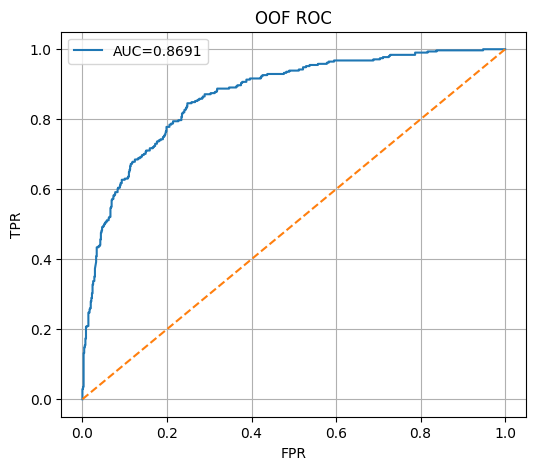

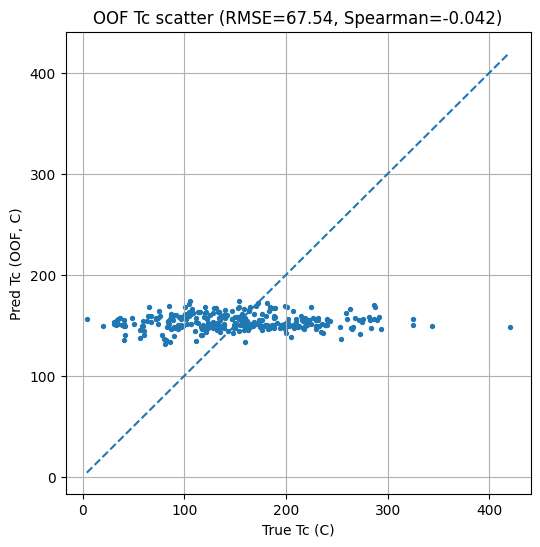

In [8]:
# ROC curve (OOF)
fpr, tpr, _ = roc_curve(y_cls, oof_prob)
auc = roc_auc_score(y_cls, oof_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC={auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("OOF ROC")
plt.legend()
plt.grid(True)
plt.show()

# Pred vs Actual scatter for Tc (LC only)
mask = (y_cls == 1) & np.isfinite(y_tc) & np.isfinite(oof_tc_pred)
if mask.sum() > 3:
    rho = spearmanr(y_tc[mask], oof_tc_pred[mask]).correlation
    rmse = root_mean_squared_error(y_tc[mask], oof_tc_pred[mask])

    plt.figure(figsize=(6, 6))
    plt.scatter(y_tc[mask], oof_tc_pred[mask], s=8)
    mn = min(np.min(y_tc[mask]), np.min(oof_tc_pred[mask]))
    mx = max(np.max(y_tc[mask]), np.max(oof_tc_pred[mask]))
    plt.plot([mn, mx], [mn, mx], linestyle="--")
    plt.xlabel("True Tc (C)")
    plt.ylabel("Pred Tc (OOF, C)")
    plt.title(f"OOF Tc scatter (RMSE={rmse:.2f}, Spearman={rho:.3f})")
    plt.grid(True)
    plt.show()

## 7. 全データで再学習して test 予測と submission 作成

In [9]:
# Full fit classification
run_full_cls = wandb.init(
    entity=os.environ.get("WANDB_ENTITY") or None,
    project=os.environ.get("WANDB_PROJECT") or None,
    group=CLS_GROUP,
    name="cls-fullfit",
    job_type="fullfit",
    tags=tags,
    reinit=True,
    config={"seed": SEED, "task": "classification_fullfit", "params": params_cls},
)

dtrain_full = lgb.Dataset(X, label=y_cls)
booster_cls_full = lgb.train(
    params_cls,
    dtrain_full,
    valid_sets=[dtrain_full],
    valid_names=["train"],
    num_boost_round=int(np.median([500, 800])),  # 軽めに。必要なら増やす
    callbacks=[
        wandb_callback(),
        lgb.log_evaluation(period=50),
    ],
)
pred_prob_test = booster_cls_full.predict(X_test)
log_summary(booster_cls_full, save_model_checkpoint=True)
run_full_cls.finish()

# Full fit Tc regression (LC only)
mask_lc = (y_cls == 1) & np.isfinite(y_tc)
pred_tc_test = np.full(len(test), np.nan, dtype=float)

if mask_lc.sum() >= 20:
    run_full_tc = wandb.init(
        entity=os.environ.get("WANDB_ENTITY") or None,
        project=os.environ.get("WANDB_PROJECT") or None,
        group=TC_GROUP,
        name="tc-fullfit",
        job_type="fullfit",
        tags=tags,
        reinit=True,
        config={"seed": SEED, "task": "tc_fullfit", "params": params_tc, "train_lc_rows": int(mask_lc.sum())},
    )
    dtrain_tc_full = lgb.Dataset(X[mask_lc], label=y_tc[mask_lc])
    booster_tc_full = lgb.train(
        params_tc,
        dtrain_tc_full,
        valid_sets=[dtrain_tc_full],
        valid_names=["train"],
        num_boost_round=int(np.median([800, 1200])),
        callbacks=[
            wandb_callback(),
            lgb.log_evaluation(period=50),
        ],
    )
    pred_tc_test = booster_tc_full.predict(X_test)
    log_summary(booster_tc_full, save_model_checkpoint=True)
    run_full_tc.finish()

# Optional Tm fullfit
pred_tm_test = np.full(len(test), np.nan, dtype=float)
if y_tm is not None and np.isfinite(y_tm).sum() >= 20:
    run_full_tm = wandb.init(
        entity=os.environ.get("WANDB_ENTITY") or None,
        project=os.environ.get("WANDB_PROJECT") or None,
        group=TM_GROUP,
        name="tm-fullfit",
        job_type="fullfit",
        tags=tags,
        reinit=True,
        config={"seed": SEED, "task": "tm_fullfit", "params": params_tm},
    )
    mask_tm = np.isfinite(y_tm)
    dtrain_tm_full = lgb.Dataset(X[mask_tm], label=y_tm[mask_tm])
    booster_tm_full = lgb.train(
        params_tm,
        dtrain_tm_full,
        valid_sets=[dtrain_tm_full],
        valid_names=["train"],
        num_boost_round=int(np.median([800, 1200])),
        callbacks=[wandb_callback(), lgb.log_evaluation(period=50)],
    )
    pred_tm_test = booster_tm_full.predict(X_test)
    log_summary(booster_tm_full, save_model_checkpoint=True)
    run_full_tm.finish()

# Submission (列名は sample_submission に合わせる)
# この部分はコンペの提出形式に依存します。sample_submission.csv を優先して合わせます。
sub = sub.copy()

# よくあるケース: id 列 + 予測列
id_cols = [c for c in sub.columns if c.lower() in ["id", "sample_id"]]
pred_cols = [c for c in sub.columns if c not in id_cols]

def _set_if_exists(colname, values):
    if colname in sub.columns:
        sub[colname] = values
        return True
    return False

set_any = False
set_any |= _set_if_exists("is_thermotropic_lc", pred_prob_test)
set_any |= _set_if_exists("clearing_point_celsius", pred_tc_test)
if TM_COL is not None:
    set_any |= _set_if_exists(TM_COL, pred_tm_test)

# 列名が違う場合のフォールバック
if not set_any and len(pred_cols) >= 2:
    sub[pred_cols[0]] = pred_prob_test
    sub[pred_cols[1]] = pred_tc_test

SUB_OUT = "submission.csv"
sub.to_csv(SUB_OUT, index=False)
print("Saved:", SUB_OUT)
display(sub.head())

wandb: setting up run v2obofzw
wandb: Tracking run with wandb version 0.22.2
wandb: Run data is saved locally in /kaggle/working/wandb/run-20251219_120413-v2obofzw
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run cls-fullfit
wandb: ⭐️ View project at https://wandb.ai/wandb-japan/data-science-osaka-winter-2025-simple-baseline
wandb: 🚀 View run at https://wandb.ai/wandb-japan/data-science-osaka-winter-2025-simple-baseline/runs/v2obofzw


[50]	train's auc: 0.989775
[100]	train's auc: 0.999063
[150]	train's auc: 0.999844
[200]	train's auc: 0.999975
[250]	train's auc: 0.999993
[300]	train's auc: 0.999993
[350]	train's auc: 0.999993
[400]	train's auc: 0.999993
[450]	train's auc: 0.999993
[500]	train's auc: 0.999993
[550]	train's auc: 0.999993
[600]	train's auc: 0.999993
[650]	train's auc: 0.999993


wandb: updating run metadata; uploading artifact run-v2obofzw-FeatureImportance_table-Q3A4FA; uploading artifact model_v2obofzw
wandb: uploading artifact model_v2obofzw
wandb: 
wandb: Run history:
wandb: iteration ▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇████
wandb: train_auc ▁▁▄▅▆███████████████████████████████████
wandb: 
wandb: Run summary:
wandb: best_iteration 0
wandb:      iteration 649
wandb: 
wandb: 🚀 View run cls-fullfit at: https://wandb.ai/wandb-japan/data-science-osaka-winter-2025-simple-baseline/runs/v2obofzw
wandb: ⭐️ View project at: https://wandb.ai/wandb-japan/data-science-osaka-winter-2025-simple-baseline
wandb: Synced 5 W&B file(s), 1 media file(s), 4 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20251219_120413-v2obofzw/logs
wandb: setting up run b80inefm
wandb: Tracking run with wandb version 0.22.2
wandb: Run data is saved locally in /kaggle/working/wandb/run-20251219_120420-b80inefm
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing

[50]	train's rmse: 53.2814
[100]	train's rmse: 46.1558
[150]	train's rmse: 41.4342
[200]	train's rmse: 37.7864
[250]	train's rmse: 34.7814
[300]	train's rmse: 32.114
[350]	train's rmse: 29.9061
[400]	train's rmse: 27.8743
[450]	train's rmse: 26.1296
[500]	train's rmse: 24.4606
[550]	train's rmse: 23.0542
[600]	train's rmse: 21.7456
[650]	train's rmse: 20.6143
[700]	train's rmse: 19.6046
[750]	train's rmse: 18.5911
[800]	train's rmse: 17.7113
[850]	train's rmse: 16.9121
[900]	train's rmse: 16.1203
[950]	train's rmse: 15.359
[1000]	train's rmse: 14.6771


wandb: updating run metadata; uploading artifact run-b80inefm-FeatureImportance_table-LsbmbQ; uploading artifact model_b80inefm
wandb: uploading artifact model_b80inefm
wandb: 
wandb: Run history:
wandb:  iteration ▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██
wandb: train_rmse ██▇▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb: best_iteration 0
wandb:      iteration 999
wandb: 
wandb: 🚀 View run tc-fullfit at: https://wandb.ai/wandb-japan/data-science-osaka-winter-2025-simple-baseline/runs/b80inefm
wandb: ⭐️ View project at: https://wandb.ai/wandb-japan/data-science-osaka-winter-2025-simple-baseline
wandb: Synced 5 W&B file(s), 1 media file(s), 4 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20251219_120420-b80inefm/logs


Saved: submission.csv


,row_id,prediction
0,0.999932,183.722850
1,0.000003,165.327255
2,0.109978,116.868959
3,0.000039,164.396828
4,0.139889,101.426693


## 8. W&B Table: train と test を別テーブルで保存

In [10]:
WANDB_MAX_TABLE_ROWS = int(os.environ.get("WANDB_MAX_TABLE_ROWS", "99999"))
WANDB_MAX_IMAGE_ROWS = int(os.environ.get("WANDB_MAX_IMAGE_ROWS", "99999"))

def _clean_smiles(x):
    if x is None:
        return None
    if not isinstance(x, str):
        return None
    s = x.strip()
    if not s or s.lower() in {"nan", "none", "null"}:
        return None
    return s

def safe_wandb_molecule(smiles: str):
    try:
        s = smiles.strip() if isinstance(smiles, str) else None
        if not s:
            return None
        return wandb.Molecule.from_smiles(s)   # 添付と同じ
    except Exception:
        return None  # 添付は np.nan でもOK


def safe_wandb_image_from_smiles(smiles: str, size=(300, 300)):
    try:
        s = _clean_smiles(smiles)
        if s is None:
            return None
        mol = Chem.MolFromSmiles(s)
        if mol is None:
            return None
        img = Draw.MolToImage(mol, size=size)
        return wandb.Image(img)
    except Exception:
        return None

def build_table(
    df: pd.DataFrame,
    split: str,
    smiles_col: str,
    ecfp4_list: list,
    prob_col: str,
    tc_pred_col: str,
    tc_true_col: str=None,
    tm_pred_col: str=None,
    tm_true_col: str=None
):
    # 元の列は全保持したまま、必要列を追加
    out = df.copy()

    # Row cap は先に適用（無駄な分子生成や画像生成を避ける）
    if WANDB_MAX_TABLE_ROWS > 0:
        out = out.iloc[:min(len(out), WANDB_MAX_TABLE_ROWS)].copy()

    out["split"] = split
    out["ecfp4_vec"] = ecfp4_list[:len(out)]

    out["pred_prob_is_thermotropic_lc"] = out[prob_col].values
    out["pred_tc_celsius"] = out[tc_pred_col].values
    out["tc_true_celsius"] = out[tc_true_col].values if tc_true_col is not None else np.nan

    out["pred_tm_celsius"] = out[tm_pred_col].values if tm_pred_col is not None else np.nan
    out["tm_true_celsius"] = out[tm_true_col].values if tm_true_col is not None else np.nan

    # wandb.Molecule は全行に入れる（UIで回転確認するため）
    smiles_vals = out[smiles_col].tolist()
    out["molecule"] = [safe_wandb_molecule(s) for s in smiles_vals]

    # 画像は上限を設ける（巨大アップロード対策）
    n = len(out)
    cap = n if WANDB_MAX_IMAGE_ROWS <= 0 else min(n, WANDB_MAX_IMAGE_ROWS)
    images = [None] * n
    for i in range(cap):
        images[i] = safe_wandb_image_from_smiles(smiles_vals[i])
    out["mol_image"] = images

    # wandb.Table を row-wise に構築（object列を確実に保持）
    cols = list(out.columns)
    table = wandb.Table(columns=cols)
    for _, r in out.iterrows():
        table.add_data(*[r[c] for c in cols])

    return table, out

# Prepare train/test dataframes with predictions, without losing any original columns
train_pred_df = train.copy()
train_pred_df["oof_prob_is_thermotropic_lc"] = oof_prob
train_pred_df["oof_tc_celsius"] = oof_tc_pred
if oof_tm_pred is not None:
    train_pred_df["oof_tm_celsius"] = oof_tm_pred

test_pred_df = test.copy()
test_pred_df["pred_prob_is_thermotropic_lc"] = pred_prob_test
test_pred_df["pred_tc_celsius"] = pred_tc_test
test_pred_df["pred_tm_celsius"] = pred_tm_test

# Train table includes Tc actual + OOF pred
train_table, train_table_df = build_table(
    train_pred_df,
    split="train",
    smiles_col=SMILES_COL,
    ecfp4_list=train_ecfp4_list,
    prob_col="oof_prob_is_thermotropic_lc",
    tc_pred_col="oof_tc_celsius",
    tc_true_col=TC_COL,  # Actual Tc
    tm_pred_col="oof_tm_celsius" if oof_tm_pred is not None else None,
    tm_true_col=TM_COL,
)

# Test table includes pred only (no true)
test_table, test_table_df = build_table(
    test_pred_df,
    split="test",
    smiles_col=SMILES_COL,
    ecfp4_list=test_ecfp4_list,
    prob_col="pred_prob_is_thermotropic_lc",
    tc_pred_col="pred_tc_celsius",
    tc_true_col=None,
    tm_pred_col="pred_tm_celsius",
    tm_true_col=None,
)

run_tables = wandb.init(
    entity=os.environ.get("WANDB_ENTITY") or None,
    project=os.environ.get("WANDB_PROJECT") or None,
    group=TABLE_GROUP,
    name="tables",
    job_type="tables",
    tags=tags,
    reinit=True,
    config={
        "base_group": BASE_GROUP,
        "max_table_rows": WANDB_MAX_TABLE_ROWS,
        "max_image_rows": WANDB_MAX_IMAGE_ROWS,
        "smiles_col": SMILES_COL,
        "tc_col": TC_COL,
        "tm_col": TM_COL,
    },
)

run_tables.log({
    "data/train_table": train_table,
    "data/test_table": test_table,
})

# Also log the CSVs as artifacts for reproducibility
artifact = wandb.Artifact("lc-preds", type="dataset")
TRAIN_PRED_CSV = "train_with_oof_preds.csv"
TEST_PRED_CSV  = "test_with_preds.csv"
train_table_df.to_csv(TRAIN_PRED_CSV, index=False)
test_table_df.to_csv(TEST_PRED_CSV, index=False)
artifact.add_file(TRAIN_PRED_CSV)
artifact.add_file(TEST_PRED_CSV)
artifact.add_file(SUB_OUT)
run_tables.log_artifact(artifact)

run_tables.finish()

print("Logged W&B tables and artifacts.")
print("Train table columns:", len(train_table_df.columns))
print("Test table columns :", len(test_table_df.columns))


[12:04:27] UFFTYPER: Unrecognized atom type: *_ (0)
[12:04:27] UFFTYPER: Unrecognized atom type: *_ (16)
[12:04:27] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 49 50 51 52 76 77 78
[12:04:27] Can't kekulize mol.  Unkekulized atoms: 16 17 19
[12:04:37] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 48 63 78
[12:04:38] Can't kekulize mol.  Unkekulized atoms: 13 14 15 105 106
[12:04:39] UFFTYPER: Unrecognized atom type: *_ (0)
[12:04:39] UFFTYPER: Unrecognized atom type: *_ (18)
[12:04:39] UFFTYPER: Unrecognized atom type: *_ (0)
[12:04:39] UFFTYPER: Unrecognized atom type: *_ (28)
[12:04:41] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 145 146 147
[12:04:43] UFFTYPER: Unrecognized atom type: Fe2+2 (0)
[12:04:44] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27 54 55 56 57 84 85 86
[12:04:45] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 46 47 48 49 69 70 71
[12:04:50] UFFTYPER: Unrecognized atom type: Zr (0)
[12:04:57] Can't kekulize mol.  Unkekulize

Logged W&B tables and artifacts.
Train table columns: 22
Test table columns : 15
